In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
tqdm.pandas()
import os
import gc
import random
from glob import glob
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
import warnings
import seaborn as sns
import pickle
import json
import re
import time
import sys
from requests import get
import multiprocessing
import joblib

from pathlib import Path

from gensim.models import word2vec, KeyedVectors

class CFG:
    seed = 46
    target = "point_of_interest"
    n_neighbors = 10
    n_splits = 3

    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]

random.seed(CFG.seed)
os.environ["PYTHONHASHSEED"] = str(CFG.seed)
np.random.seed(CFG.seed)

plt.rcParams["font.size"] = 13
warnings.filterwarnings('ignore')

%cd /content/drive/MyDrive/Kaggle/Foursquare/Notebook

/content/drive/MyDrive/Kaggle/Foursquare/Notebook


In [ ]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from time import time

def decorate(s: str, decoration=None):
    if decoration is None:
        decoration = '★' * 20

    return ' '.join([decoration, str(s), decoration])

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' ', verbose=0):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None
        self.verbose = verbose

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        if self.verbose is None:
            return
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [3]:
!pip install texthero
import texthero as hero

     |████████████████████████████████| 1.5 MB 5.9 MB/s 
     |████████████████████████████████| 235 kB 63.9 MB/s 
     |████████████████████████████████| 749 kB 52.4 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
import nltk

nltk.download('stopwords')
os.listdir(os.path.expanduser('~/nltk_data/corpora/stopwords/'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['azerbaijani',
 'danish',
 'arabic',
 'russian',
 'kazakh',
 'bengali',
 'README',
 'finnish',
 'portuguese',
 'greek',
 'swedish',
 'french',
 'dutch',
 'english',
 'slovene',
 'spanish',
 'nepali',
 'indonesian',
 'tajik',
 'german',
 'hungarian',
 'turkish',
 'italian',
 'norwegian',
 'romanian']

In [65]:
custom_stopwords = []
for lang in ['azerbaijani',
 'danish',
 'arabic',
 'russian',
 'kazakh',
 'bengali',
 'README',
 'finnish',
 'portuguese',
 'greek',
 'swedish',
 'french',
 'dutch',
 'english',
 'slovene',
 'spanish',
 'nepali',
 'indonesian',
 'tajik',
 'german',
 'hungarian',
 'turkish',
 'italian',
 'norwegian',
 'romanian']:
    print(nltk.corpus.stopwords.words(lang))
    custom_stopwords += nltk.corpus.stopwords.words(lang)
chinese_stopwords = [k.strip() for k in open('../Dataset/Chinese_stopwords/scu_stopwords.txt', encoding='utf8').readlines() if k.strip() != '']
print(chinese_stopwords)
custom_stopwords += chinese_stopwords
custom_stopwords = list(set(custom_stopwords))

['a', 'ad', 'altı', 'altmış', 'amma', 'arasında', 'artıq', 'ay', 'az', 'bax', 'belə', 'bəli', 'bəlkə', 'beş', 'bəy', 'bəzən', 'bəzi', 'bilər', 'bir', 'biraz', 'biri', 'birşey', 'biz', 'bizim', 'bizlər', 'bu', 'buna', 'bundan', 'bunların', 'bunu', 'bunun', 'buradan', 'bütün', 'ci', 'cı', 'çox', 'cu', 'cü', 'çünki', 'da', 'daha', 'də', 'dedi', 'dək', 'dən', 'dəqiqə', 'deyil', 'dir', 'doqquz', 'doqsan', 'dörd', 'düz', 'ə', 'edən', 'edir', 'əgər', 'əlbəttə', 'elə', 'əlli', 'ən', 'əslində', 'et', 'etdi', 'etmə', 'etmək', 'faiz', 'gilə', 'görə', 'ha', 'haqqında', 'harada', 'hə', 'heç', 'həm', 'həmin', 'həmişə', 'hər', 'ı', 'idi', 'iki', 'il', 'ildə', 'ilə', 'ilk', 'in', 'indi', 'isə', 'istifadə', 'iyirmi', 'ki', 'kim', 'kimə', 'kimi', 'lakin', 'lap', 'məhz', 'mən', 'mənə', 'mirşey', 'nə', 'nəhayət', 'niyə', 'o', 'obirisi', 'of', 'olan', 'olar', 'olaraq', 'oldu', 'olduğu', 'olmadı', 'olmaz', 'olmuşdur', 'olsun', 'olur', 'on', 'ona', 'ondan', 'onlar', 'onlardan', 'onların ', 'onsuzda', 'onu', 

In [6]:
train = pd.read_csv("../Input/train.csv")
test = pd.read_csv("../Input/test.csv")
test[CFG.target] = "TEST"

train.head(1)

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e


In [7]:
train['name'] = train['name'].fillna("NaN")
test['name'] = test['name'].fillna("NaN")
train['categories'] = train['categories'].fillna("NaN")
test['categories'] = test['categories'].fillna("NaN")

### nameの前処理

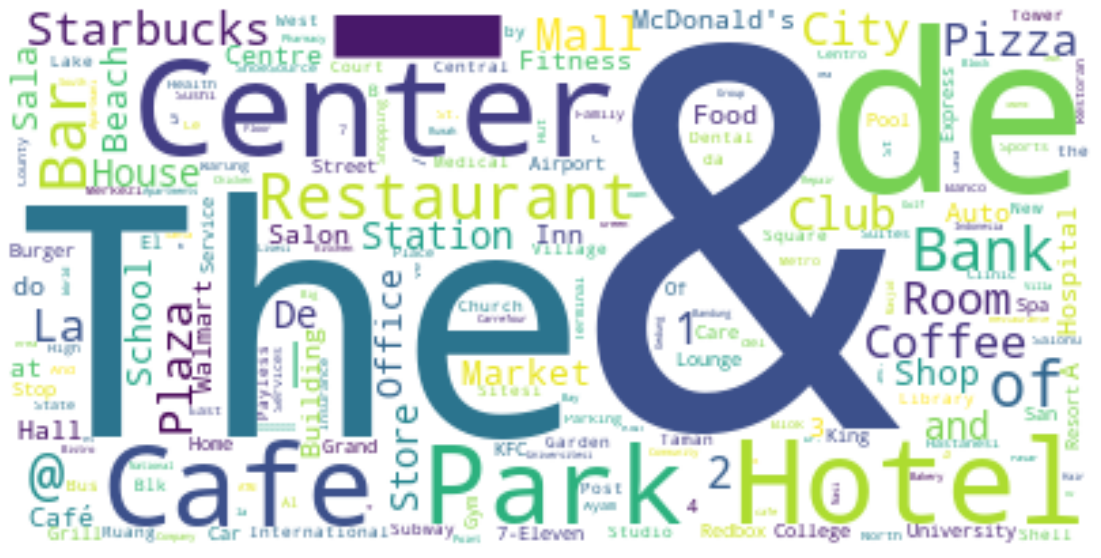

In [15]:
hero.visualization.wordcloud(train['name'], colormap='viridis', background_color='white')

In [45]:
train['name'] = hero.clean(train['name'], pipeline=[
    hero.preprocessing.fillna,
    lambda x: hero.preprocessing.remove_stopwords(x, stopwords=custom_stopwords),
    hero.preprocessing.lowercase,
    hero.preprocessing.remove_digits,
    hero.preprocessing.remove_punctuation,
    hero.preprocessing.remove_diacritics,
    lambda x: hero.preprocessing.remove_stopwords(x, stopwords=custom_stopwords)
])

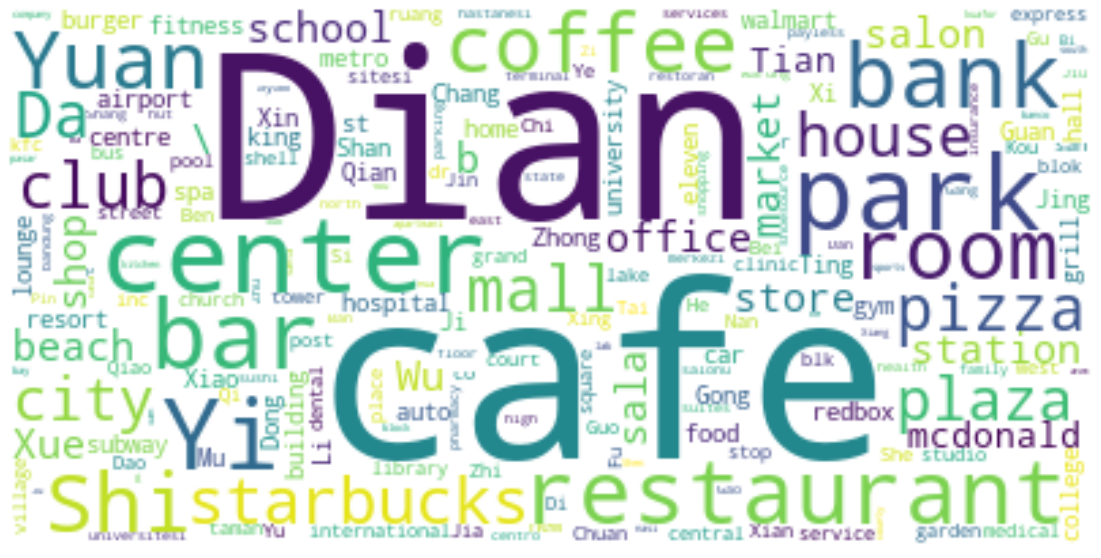

In [46]:
hero.visualization.wordcloud(train['name'], colormap='viridis', background_color='white')

### categoriesの前処理

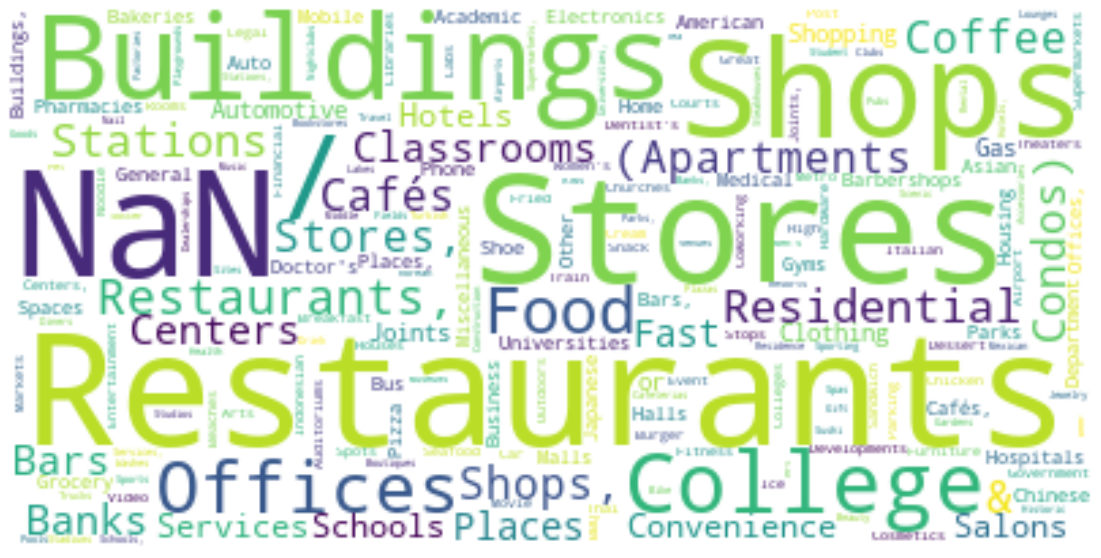

In [66]:
hero.visualization.wordcloud(train['categories'], colormap='viridis', background_color='white')

In [67]:
train['categories'] = hero.clean(train['categories'], pipeline=[
    hero.preprocessing.fillna,
    lambda x: hero.preprocessing.remove_stopwords(x, stopwords=custom_stopwords),
    hero.preprocessing.lowercase,
    hero.preprocessing.remove_digits,
    hero.preprocessing.remove_punctuation,
    hero.preprocessing.remove_diacritics,
    lambda x: hero.preprocessing.remove_stopwords(x, stopwords=custom_stopwords)
])

KeyboardInterrupt: ignored

In [ ]:
hero.visualization.wordcloud(train['categories'], colormap='viridis', background_color='white')

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

In [71]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=100000)),
    ('svd', TruncatedSVD(n_components=50)),
])

z = pipeline.fit_transform(train['name'])

In [85]:
# !git clone https://github.com/DmitryUlyanov/Multicore-TSNE.git
!cd Multicore-TSNE/
!python setup.py install
!pip install .

python3: can't open file 'setup.py': [Errno 2] No such file or directory
ERROR: Directory '.' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.


In [79]:
from MulticoreTSNE import MulticoreTSNE as TSNE

# tsneおそいのでちょっと時間かかる
with Timer(prefix='run tsne'):
    tsne = TSNE(n_jobs=-1)
    embedding = tsne.fit_transform(z)

ModuleNotFoundError: ignored

In [ ]:
bin_labels = pd.cut(train['point_of_interest'], bins=5)
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(*embedding.T, c=bin_labels.cat.codes, s=20, alpha=.8, cmap='cividis')
ax.grid()